# The demonstration of the tropical precipitation module for ICON data

## Structure


1. [Load of packages, modules and data](#1-load-of-packages-modules-and-data)

2. [Calculation of histogram of precipitation/tropical precipitation](#2-calculation-of-histogram-of-precipitationtropicalprecipitation)

    2.1. [with manual data preprocessing](#21-diagnostic-with-manual-data-preprocessing)

    2.2 [automatic data preprocessing](#22-diagnostic-with-automatic-data-preprocessing)

    2.3. [with non uniform binning](#23-histogram-with-not-uniform-binning)

    2.4. [Calculation time expectation for a total dataset](#24-expected-calculation-time-for-entire-dataset)
 
3. [Histograms of tropical precipitation](#3-histograms-of-tropical-precipitation)

    3.1. [Plot of mean and median value of precipitation rate](#41-plot-of-mean-and-median-value-of-precipitation-rate)

[Go to the end of file](#the-end)

#

## 1. Load of  packages, modules and data

In [3]:
import sys

from aqua import Reader, catalogue
from aqua.benchmark import functions_for_xarrays,  graphic_creator, time_functions
sys.path.insert(0, '../')
from src.trop_prec_diagnostic import TR_PR_Diagnostic as TR_PR_Diag

#### ICON data

In [4]:
reader = Reader(model="ICON", exp="ngc2009", source="atm_2d_ml_R02B09", regrid="r010")
icon = reader.retrieve(regrid=True)


/home/b/b382267/mambaforge/envs/tropical-rainfall/lib/python3.10/site-packages/smmregrid/regrid.py:537: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  out = source_data.map(self.regrid, keep_attrs=True)
/home/b/b382267/mambaforge/envs/tropical-rainfall/lib/python3.10/site-packages/smmregrid/regrid.py:537: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.res

Use it a waight in histograms

In [10]:
reader.grid_area

<xarray.DataArray 'cell_area' (lat: 1800, lon: 3600)>
dask.array<open_dataset-4aeb6b2f3d9786709de8e84b837b8c0fcell_area, shape=(1800, 3600), dtype=float64, chunksize=(1800, 3600), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.5 359.6 359.7 359.8 359.9
  * lat      (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
    time     datetime64[ns] ...
Attributes:
    standard_name:  area
    long_name:      area of grid cell
    units:          m2

In [11]:
icon

<xarray.Dataset>
Dimensions:   (time: 37009, lat: 1800, lon: 3600)
Coordinates:
  * time      (time) datetime64[ns] 2020-01-20 ... 2022-03-01
  * lat       (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
  * lon       (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9
Data variables: (12/33)
    cfh_lnd   (time, lat, lon) float64 dask.array<chunksize=(6, 1800, 3600), meta=np.ndarray>
    tciw      (time, lat, lon) float64 dask.array<chunksize=(6, 1800, 3600), meta=np.ndarray>
    tclw      (time, lat, lon) float64 dask.array<chunksize=(6, 1800, 3600), meta=np.ndarray>
    cptgzvi   (time, lat, lon) float64 dask.array<chunksize=(6, 1800, 3600), meta=np.ndarray>
    mslhfl    (time, lat, lon) float64 dask.array<chunksize=(6, 1800, 3600), meta=np.ndarray>
    msshfl    (time, lat, lon) float64 dask.array<chunksize=(6, 1800, 3600), meta=np.ndarray>
    ...        ...
    10u       (time, lat, lon) float64 dask.array<chunksize=(6, 1800, 3600), meta=np.ndarray>
    10v       (time, lat, lon) float64 dask.array<chunksize=(6, 1800, 3600), meta=np.ndarray>
    msntrf    (time, lat, lon) float64 dask.array<chunksize=(6, 1800, 3600), meta=np.ndarray>
    mtntrf    (time, lat, lon) float64 dask.array<chunksize=(6, 1800, 3600), meta=np.ndarray>
    msnsrf    (time, lat, lon) float64 dask.array<chunksize=(6, 1800, 3600), meta=np.ndarray>
    mtnsrf    (time, lat, lon) float64 dask.array<chunksize=(6, 1800, 3600), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    comment:              Sapphire Dyamond (k203123) on l40687 (Linux 4.18.0-...
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    history:              ./icon at 20220512 1522142023-04-26 18:58:45 retrie...
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    number_of_grid_used:  15
    references:           see MPIM/DWD publications
    source:               git@gitlab.dkrz.de:icon/icon-aes.git@87a1eaded69e87...
    title:                ICON simulation
    uuidOfHGrid:          0f1e7d66-637e-11e8-913b-51232bb4d8f9

## 2. Calculation of histogram of precipitation/tropicalprecipitation


### 2.1. Diagnostic with manual data preprocessing

#### Initializing the class object and setting the class attributes

In [5]:
diag = TR_PR_Diag(num_of_bins = 20, first_edge = 0, width_of_bin = 1*10**(-6)/15)

#### Selecting the time range

In [6]:
icon_chunk = icon["tprate"][10:30,:] 

#### Selecting the tropical latitudes

#Select the latitudes ...ot latitude band! `Think

In [7]:
icon_chunk_trop = diag.ds_per_lat_range(icon_chunk)
icon_chunk_trop

<xarray.DataArray 'tprate' (time: 20, lat: 200, lon: 3600)>
dask.array<where, shape=(20, 200, 3600), dtype=float64, chunksize=(6, 200, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20T05:00:00 ... 2020-01-20T14:30:00
  * lat      (lat) float64 -9.95 -9.85 -9.75 -9.65 -9.55 ... 9.65 9.75 9.85 9.95
  * lon      (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.5 359.6 359.7 359.8 359.9
Attributes: (12/16)
    CDI_grid_type:                unstructured
    cell_methods:                 t: mean
    long_name:                    Mean total precipitation rate
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    ...                           ...
    shortName:                    tprate
    target_units:                 m s**-1
    factor:                       0.001
    offset:                       0
    src_units:                    kg m-2 s-1
    units_fixed:                  1

In [8]:
type(icon_chunk_trop)

xarray.core.dataarray.DataArray

In [9]:
icon_chunk_trop

<xarray.DataArray 'tprate' (time: 20, lat: 200, lon: 3600)>
dask.array<where, shape=(20, 200, 3600), dtype=float64, chunksize=(6, 200, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20T05:00:00 ... 2020-01-20T14:30:00
  * lat      (lat) float64 -9.95 -9.85 -9.75 -9.65 -9.55 ... 9.65 9.75 9.85 9.95
  * lon      (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.5 359.6 359.7 359.8 359.9
Attributes: (12/16)
    CDI_grid_type:                unstructured
    cell_methods:                 t: mean
    long_name:                    Mean total precipitation rate
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    ...                           ...
    shortName:                    tprate
    target_units:                 m s**-1
    factor:                       0.001
    offset:                       0
    src_units:                    kg m-2 s-1
    units_fixed:                  1

#### Updating the xaarray attributes: passing the attributes of entire dataset into dataset of variable 

In [ ]:
from aqua.benchmark.functions_for_xarrays import xarray_attribute_update as xarray_attribute_update
icon_chunk=xarray_attribute_update (icon_chunk, icon)

#### Fastest histogram

In [28]:
hist_icon_trop  = diag.hist1d_fast(icon_chunk_trop,  preprocess = False)
hist_icon_trop

<xarray.DataArray (bin: 20)>
array([1.3752611e+07, 1.5362500e+05, 8.1618000e+04, 5.2975000e+04,
       3.8408000e+04, 3.0176000e+04, 2.3935000e+04, 1.9934000e+04,
       1.6979000e+04, 1.4675000e+04, 1.2811000e+04, 1.1253000e+04,
       9.8400000e+03, 8.9220000e+03, 8.2180000e+03, 7.5280000e+03,
       6.7210000e+03, 6.4510000e+03, 5.8300000e+03, 5.2700000e+03])
Coordinates:
  * bin      (bin) float64 0.0 6.667e-08 1.333e-07 ... 1.2e-06 1.267e-06
Attributes: (12/16)
    CDI_grid_type:                unstructured
    cell_methods:                 t: mean
    long_name:                    Mean total precipitation rate
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    ...                           ...
    shortName:                    tprate
    target_units:                 m s**-1
    factor:                       0.001
    offset:                       0
    src_units:                    kg m-2 s-1
    units_fixed:                  1

### 2.2. Diagnostic with automatic data preprocessing

In [15]:
diag = TR_PR_Diag( trop_lat=30,  num_of_bins = 20, first_edge = 0, width_of_bin = 1*10**(-6)/15, s_time=10, f_time=11)

In [16]:
hist_icon_prepr  = diag.hist1d_fast(icon)
hist_icon_prepr 

<xarray.DataArray (bin: 20)>
array([6.99669e+05, 5.06100e+03, 2.52200e+03, 1.70300e+03, 1.21300e+03,
       8.88000e+02, 6.62000e+02, 6.17000e+02, 5.04000e+02, 4.34000e+02,
       3.54000e+02, 3.17000e+02, 3.05000e+02, 2.62000e+02, 2.46000e+02,
       2.30000e+02, 1.97000e+02, 1.68000e+02, 1.59000e+02, 1.56000e+02])
Coordinates:
  * bin      (bin) float64 0.0 6.667e-08 1.333e-07 ... 1.2e-06 1.267e-06
Attributes: (12/16)
    CDI_grid_type:                unstructured
    cell_methods:                 t: mean
    long_name:                    Mean total precipitation rate
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    ...                           ...
    shortName:                    tprate
    target_units:                 m s**-1
    factor:                       0.001
    offset:                       0
    src_units:                    kg m-2 s-1
    units_fixed:                  1

In [ ]:
aqua.Reader

### 2.3. Histogram with not uniform binning

In [11]:
#bins = np.logspace(-9, -6, 15)
bins = [1.00000000e-09, 1.63789371e-09, 2.68269580e-09, 4.39397056e-09,
       7.19685673e-09, 1.17876863e-08, 1.93069773e-08, 3.16227766e-08,
       5.17947468e-08, 8.48342898e-08, 1.38949549e-07, 2.27584593e-07,
       3.72759372e-07, 6.10540230e-07, 1.00000000e-06]

In [12]:
diag = TR_PR_Diag(bins = bins, s_time = 10, f_time = 20)

In [13]:
hist_icon_trop_logspaced  = diag.hist1d_np(icon)
hist_icon_trop_logspaced

<xarray.DataArray (bin: 14)>
array([62844, 63809, 65846, 61449, 53523, 53214, 53553, 53342, 52137,
       48620, 44220, 39205, 34007, 28806])
Coordinates:
  * bin      (bin) float64 1e-09 1.638e-09 2.683e-09 ... 3.728e-07 6.105e-07
Attributes: (12/16)
    CDI_grid_type:                unstructured
    cell_methods:                 t: mean
    long_name:                    Mean total precipitation rate
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    ...                           ...
    shortName:                    tprate
    target_units:                 m s**-1
    factor:                       0.001
    offset:                       0
    src_units:                    kg m-2 s-1
    units_fixed:                  1

### 2.4. Expected calculation time for entire dataset

####  Checking the calculation time of a small chunk of the dataset

In [23]:
result = %timeit -r 2 -n 1 -o  diag.hist1d_fast(icon_chunk_trop, preprocess=False)
time_fast_reg, time_fast_reg_stdev =  result.average, result.stdev 

9.06 s ± 143 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)


#### Estemated calculation time of entire dataset

In [25]:
from aqua.benchmark.time_functions import estimated_total_calc_time as estimated_total_calc_time
estimated_total_calc_time(ds_part = icon_chunk_trop, calc_time = time_fast_reg, ds_full = icon,  units='D')

(150816.8338727542, 1.7455652068605811)

#### Optimal amount of timesteps

In [26]:
from aqua.benchmark.time_functions import optimal_amount_of_timesteps as optimal_amount_of_timesteps
optimal_amount_of_timesteps(ds_part = icon_chunk_trop, calc_time = time_fast_reg,  ds_full = icon, wanted_time ='3H')

(0.07161004327349875, 2650)

#

## 3. Histograms of tropical precipitation

#### We can make plots of frequency histograms. We need to set `pdf` argument in `hist_plot` function to `False` 

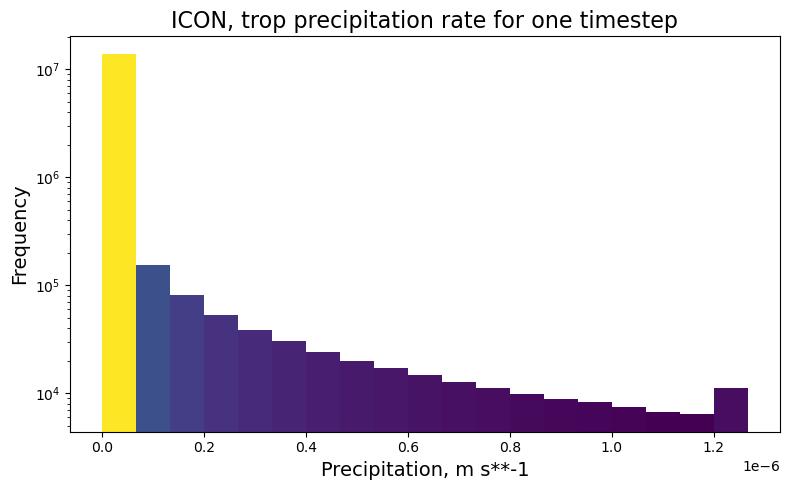

In [29]:
diag.hist_plot(hist_icon_trop, pdf = False, smooth = False, label='ICON/ICON_trop', plot_title = "ICON, trop precipitation rate for one timestep")

#### Or we can create a pdf histogram by setting `pdf = True` in `hist_plot` function. (Default value of `pdf` is `True`)

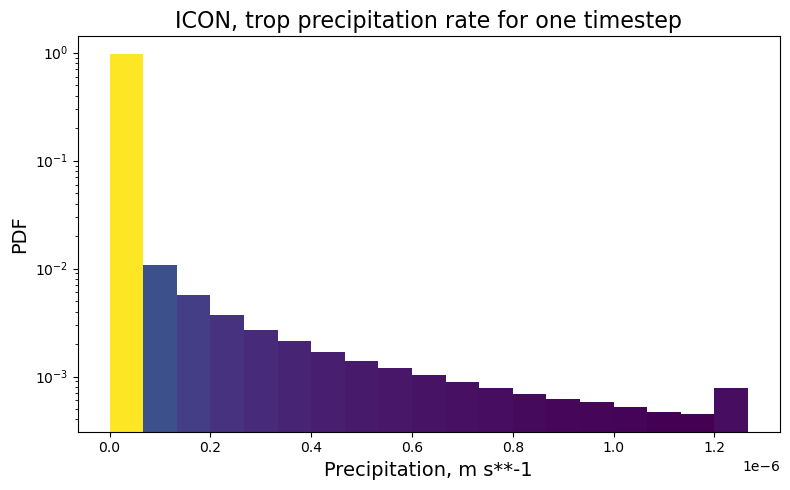

In [30]:
diag.hist_plot(hist_icon_trop, pdf = True, smooth = False, label='ICON/ICON_trop', plot_title = "ICON, trop precipitation rate for one timestep")

#### We can also plot typical 2D dependence of counts versus the right edge of the bins by setting the `smooth = True.` It is also a default value.

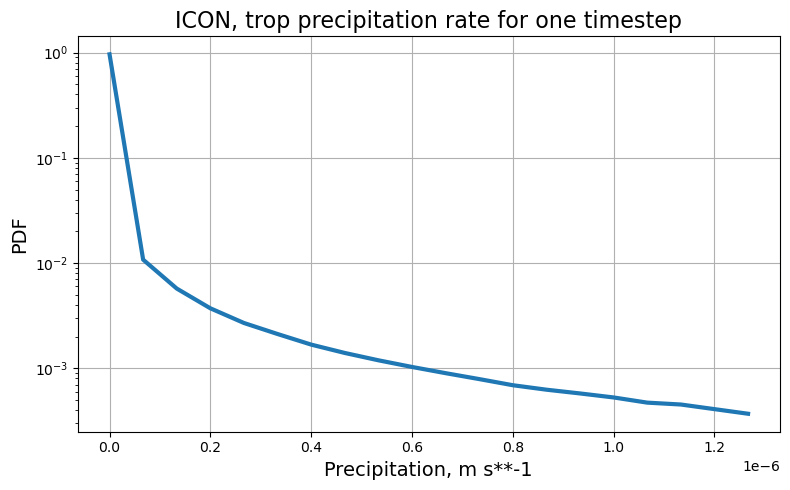

In [32]:
diag.hist_plot(hist_icon_trop, pdf = True, smooth = True, label='ICON/ICON_trop', plot_title = "ICON, trop precipitation rate for one timestep")

### Histogram of logspaced binning. Argument `xlogscale=True` setting x-axe to the log scale. By default `xlogscale=False` 

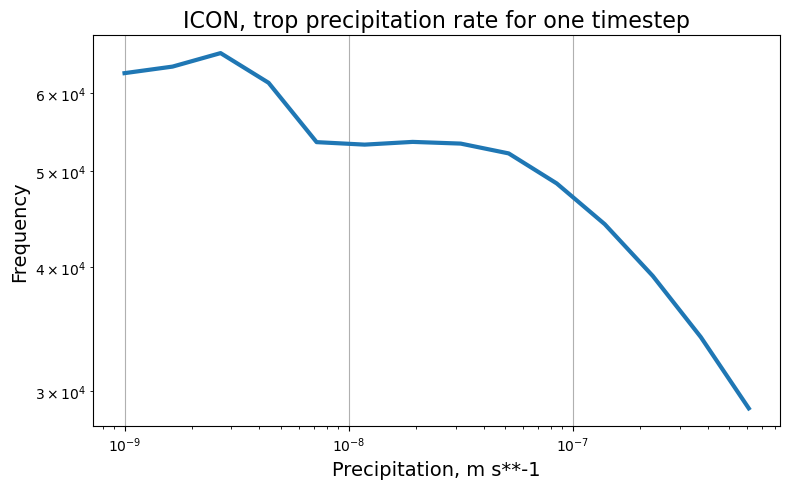

In [34]:
diag.hist_plot(hist_icon_trop_logspaced, pdf = False, smooth = True, xlogscale=True, label='ICON/ICON_trop_log', plot_title = "ICON, trop precipitation rate for one timestep")

### 3.1. Plot of mean and median value of precipitation rate

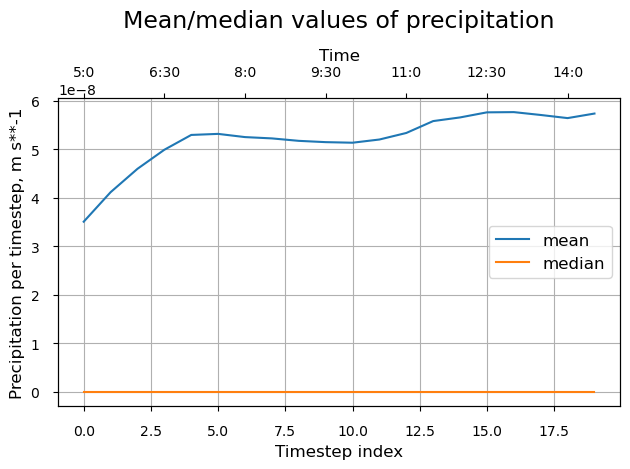

In [35]:
diag.mean_and_median_plot(icon_chunk, savelabel = 'ICON/ICON')

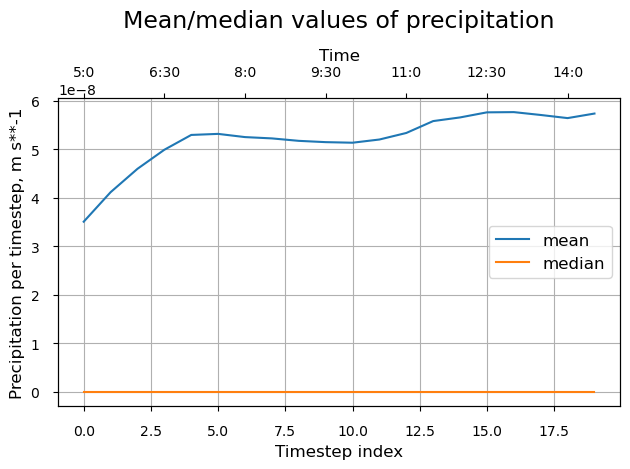

In [36]:
diag.mean_and_median_plot(icon_chunk_trop, savelabel = 'ICON/ICON_trop')

[Back to the top of file](#structure)

#

##### The end